In [1]:
%matplotlib inline

C:\Users\PG_MG\Anaconda3\envs\XAIconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PG_MG\Anaconda3\envs\XAIconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\PG_MG\Anaconda3\envs\XAIconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
print(__doc__)

import numpy as np
from sklearn.cluster import SpectralClustering
import skimage
from distutils.version import LooseVersion
import matplotlib.pyplot as plt
import random
random.seed(2020)

Automatically created module for IPython interactive environment


In [3]:
K_CLUSTERS = 4
N_NEIGHBORS = 10
H_FEATURES = 20
IM_FEATURES = 10

### Find all files of heatmaps and images. Directories to all files will be saved in correspoding lists hlist (heatmaps) and ilist (images)

In [4]:
# find all of the files in the directory
from PIL import Image, ImageEnhance
import os

hlist=[]
ilist=[]

folders=["../images/skin_lesions/h-mal/", "../images/skin_lesions/org-mal/"]
lists=[hlist,ilist]
for folder, filelist in zip(folders, lists):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png"):
                filelist.append(os.path.join(root, file))
                
print('Found ', len(hlist),' heatmap files.')
print('Found ', len(ilist),' org files.')


Found  884  heatmap files.
Found  884  org files.


### Preprocessing and loading images
Each image have to be preprocessed in the same manner. Each image should have the same size.

In [5]:
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rescale
from sklearn.feature_extraction import image
from math import sqrt
from skimage import exposure
    
heatmaps=[]
images=[]

if LooseVersion(skimage.__version__) >= '0.14':
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

# loading images
datasets = [heatmaps,images]
for files,dataset in zip(lists,datasets):
    for file in files:
        im = Image.open(file)
        enhancer = ImageEnhance.Contrast(im)
        enhanced_im = enhancer.enhance(1)
        enhanced_im=np.array(enhanced_im)
        wb_im = exposure.equalize_adapthist(enhanced_im, clip_limit=0.01)[:,:,0]
        dataset.append(wb_im.reshape(int(sqrt(wb_im.size))*int(sqrt(wb_im.size))))
        
print('Loaded ', len(heatmaps),' heatmaps.')
print('Loaded ', len(images),' images.')    

Loaded  884  heatmaps.
Loaded  884  images.


#  Reduce dimensionality and cluster
Now, all of the heatmaps will be mapped to a different representation with *isomap*. Number of pixels in the image will be reduce to selected number of features = H_FEATURES.

### Cluster only heatmaps



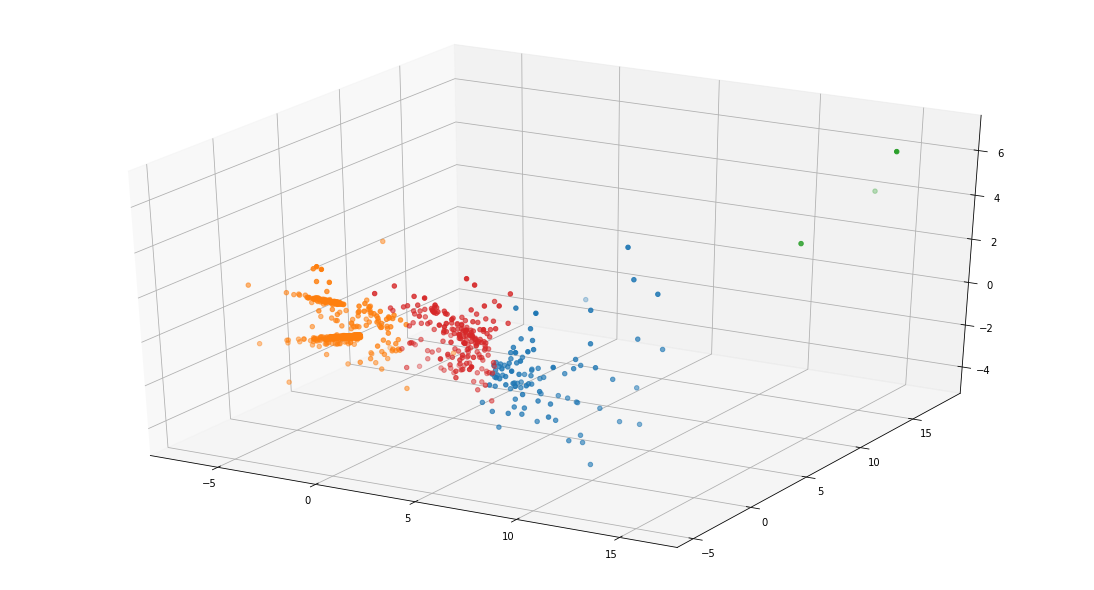

In [12]:
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import preprocessing

# create isomap 
isomap = Isomap(n_neighbors=N_NEIGHBORS,n_components=H_FEATURES,eigen_solver='arpack',path_method='FW', neighbors_algorithm='brute')
h_isomap = isomap.fit_transform(heatmaps)

# clustering isomap of heatmaps
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=0).fit(h_isomap)
labels = kmeans.predict(h_isomap)

fig=plt.figure(figsize=(15, 8))
ax = Axes3D(fig)

for cluster in range(0,K_CLUSTERS):
    ax.scatter(h_isomap[labels==cluster,0],h_isomap[labels==cluster,1],h_isomap[labels==cluster,2])


### Move images to different folder for comparison
Copy images from each cluster to a different directory. Folder is equal to cluster number

In [7]:
from shutil import copy2

for label, image in zip(labels, ilist):
    directory = "../images/clustered_images/h/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)
    
for label, heatmap in zip(labels, hlist):
    directory = "../images/clustered_heatmaps/h/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(heatmap, directory)

### Cluster only images

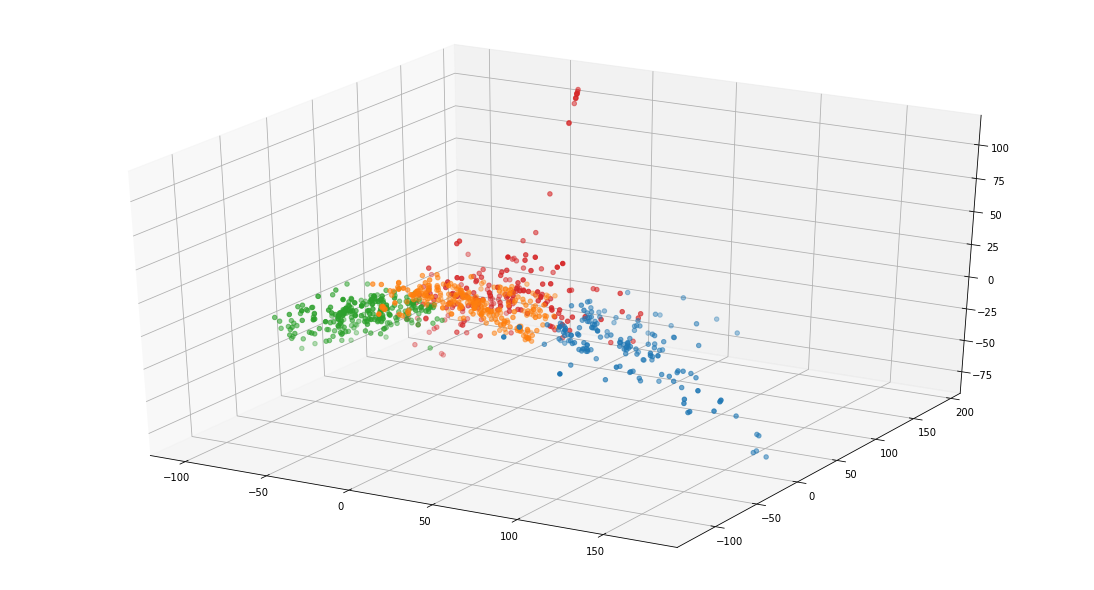

In [8]:
isomap = Isomap(n_neighbors=N_NEIGHBORS,n_components=IM_FEATURES,eigen_solver='arpack',path_method='FW', neighbors_algorithm='brute')
images_isomap= isomap.fit_transform(images)

kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=0).fit(images_isomap)
labels = kmeans.predict(images_isomap)

fig=plt.figure(figsize=(15, 8))
ax = Axes3D(fig)

for cluster in range(0,K_CLUSTERS):
    ax.scatter(images_isomap[labels==cluster,0],images_isomap[labels==cluster,1],images_isomap[labels==cluster,2])

plt.show()

In [9]:
from shutil import copy2

for label, image in zip(labels, ilist):
    directory = "../images//clustered_images/im/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)
    
for label, heatmap in zip(labels, hlist):
    directory = "../images/clustered_heatmaps/im/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(heatmap, directory)

## Cluster both images and heatmaps

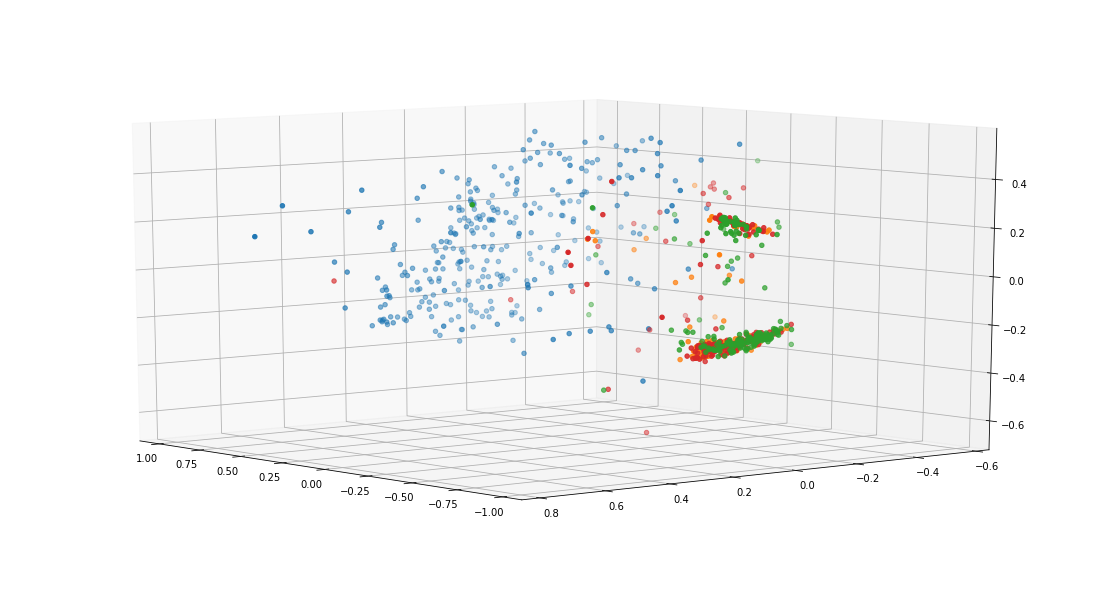

In [10]:
# both heatmaps and images
isomap=[]
isomap=np.concatenate((preprocessing.normalize(h_isomap),preprocessing.normalize(images_isomap)), axis=1)

kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=0).fit(isomap)
labels = kmeans.predict(isomap)

fig=plt.figure(figsize=(15, 8))
ax = Axes3D(fig)

for cluster in range(0,K_CLUSTERS):
    ax.scatter(isomap[labels==cluster,0],isomap[labels==cluster,1],isomap[labels==cluster,2])
ax.view_init(10, 140)
plt.show()


In [11]:
from shutil import copy2
# copy images to different folders

for label, image in zip(labels, ilist):
    directory = "../images/clustered_images/h_im/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(image, directory)
    
for label, heatmap in zip(labels, hlist):
    directory = "../images/clustered_heatmaps/h_im/" + str(label)
    if not os.path.exists(directory):
        os.makedirs(directory)
    copy2(heatmap, directory)